# Importing libraries

In [1]:
#External
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
from tqdm import tqdm
from typing import Callable
from IPython.display import clear_output

In [2]:
#Internal
from lib.system import MarketSystem
from lib.simulator import EM_Simulator
from lib.util import DataBuffer
from lib.util import OptimizerSampled
from lib.model import ModelPerceptron
from lib.critic import Critic
from lib.model import GaussianPDFModelCus
from lib.policy import Policy

## Class for main loop

In [3]:
class MonteCarloSimulationScenario:
    """Run whole REINFORCE procedure"""

    def __init__(
        self,
        train_mode: True,
        simulator: EM_Simulator,
        system: MarketSystem,
        policy: Policy,
        critic: Critic,
        N_episodes: int,
        N_iterations: int,
        discount_factor: float = 1.0,
        termination_criterion: Callable[
            [np.array, np.array, float, float], bool
        ] = lambda *args: False,
    ):
        """Initialize scenario for main loop


        Args:
            simulator (Simulator): simulator for computing system dynamics
            system (MarketSystem): system itself
            policy (PolicyREINFORCE): REINFORCE gradient stepper
            N_episodes (int): number of episodes in one iteration
            N_iterations (int): number of iterations
            discount_factor (float, optional): discount factor for running costs. Defaults to 1
            termination_criterion (Callable[[np.array, np.array, float, float], bool], optional): criterion for episode termination. Takes observation, action, running_cost, total_cost. Defaults to lambda*args:False
        """
        self.train_mode = train_mode
        self.simulator = simulator
        self.system = system
        self.policy = policy
        self.N_episodes = N_episodes
        self.N_iterations = N_iterations
        self.termination_criterion = termination_criterion
        self.discount_factor = discount_factor
        self.data_buffer = DataBuffer()
        self.critic = critic
        self.total_cost = 0
        self.total_costs_episodic = []
        self.learning_curve = []
        self.last_observations = None
        self.toe = []
        self.twap = []

    def compute_running_cost(
        self, observation: np.array, action: np.array
    ) -> float:
        """Computes running cost

        Args:
            observation (np.array): current observation
            action (np.array): current action

        Returns:
            float: running cost value
        """

        return -(observation[1] -0.001*action[0]) * action[0] +(observation[0] <0)

    def run(self) -> None:
        """Run main loop"""

        eps = 0.1
        means_total_costs = [eps]
        self.toe = []
        self.twap = []
        for iteration_idx in range(self.N_iterations):
            if iteration_idx % 10 == 0:
                clear_output(wait=True)
            toe = []
            twap = []
            for episode_idx in tqdm(range(self.N_episodes)):
                toe1 = []
                twap1 = []
                terminated = False
                while self.simulator.step():
                    (
                        observation,
                        action,
                        step_idx,
                    ) = self.simulator.get_sim_step_data()
                    new_action = (
                        self.policy.model.sample(torch.tensor(observation[:,0]).float())
                        .detach()
                        .cpu()
                        .numpy()
                    )
                    running_cost = self.compute_running_cost(
                        observation[:,0], new_action
                    )
                    discounted_running_cost = (
                        self.discount_factor ** (step_idx) * running_cost
                    )
                    self.total_cost += discounted_running_cost

                    if not terminated and self.termination_criterion(
                        observation[:,0],
                        new_action,
                        discounted_running_cost,
                        self.total_cost,
                    ):
                        terminated = True

                    if not terminated:
                        self.data_buffer.push_to_end(
                            observation=np.copy(observation[:,0]),
                            action=np.copy(new_action),
                            observation_action=np.hstack((observation[:,0], action[:1])),
                            running_cost=np.copy(running_cost),
                            discounted_running_cost=np.copy(
                                discounted_running_cost
                            ),
                            total_cost=np.copy(self.total_cost),
                            step_id=step_idx - 1,
                            episode_id=episode_idx,
                        )
                    self.system.receive_action(np.hstack((new_action,np.array([1 / (simulator.step_size * simulator.N_steps)]))))
                    toe1.append(running_cost)
                    twap1.append(observation[2,1])
                self.simulator.reset()
                toe.append(toe1)
                twap.append(twap1)
                self.total_costs_episodic.append(self.total_cost)
                self.total_cost = 0
            self.toe = toe
            self.twap = twap
            self.learning_curve.append(np.mean(self.total_costs_episodic))
            self.last_observations = pd.DataFrame(
                index=np.array(self.data_buffer.data["episode_id"]),
                data=np.array(self.data_buffer.data["observation"]),
            )
            self.last_actions = pd.DataFrame(
                index=np.array(self.data_buffer.data["episode_id"]),
                data=np.array(self.data_buffer.data["action"]),
            )
            if self.train_mode:
                self.critic.fit(self.data_buffer)
                self.policy.REINFORCE_step(self.data_buffer)

            means_total_costs.append(np.mean(self.total_costs_episodic))
            change = (means_total_costs[-1] / means_total_costs[-2] - 1) * 100
            sign = "-" if np.sign(change) == -1 else "+"
            print(
                f"Iteration: {iteration_idx + 1} / {self.N_iterations}, "
                + f"mean total cost {round(means_total_costs[-1], 2)}, "
                + f"% change: {sign}{abs(round(change,2))}, "
                + f"last observation: {self.last_observations.groupby(self.last_observations.index).last().mean().values}, "
                + f"TWAP cash: {pd.DataFrame(self.twap).mean().iloc[-1]:.3f}"
                ,
                end="\n",
            )

            self.total_costs_episodic = []

    def plot_data(self):
        """Plot learning results"""

        data = pd.Series(
            index=range(1, len(self.learning_curve) + 1), data=self.learning_curve
        )
        na_mask = data.isna()
        not_na_mask = ~na_mask
        interpolated_values = data.interpolate()
        interpolated_values[not_na_mask] = None
        data.plot(marker="o", markersize=3)
        interpolated_values.plot(linestyle="--")

        plt.title("Total cost by iteration")
        plt.xlabel("Iteration number")
        plt.ylabel("Total cost")
        plt.show()
        
        data = pd.DataFrame(self.toe).mean()
        na_mask = data.isna()
        not_na_mask = ~na_mask
        interpolated_values = data.interpolate()
        interpolated_values[not_na_mask] = None
        data.plot(marker=".", markersize=1)
        interpolated_values.plot(linestyle="--")

        plt.title("Running cost by step in last iteration")
        plt.xlabel("Step Number")
        plt.ylabel("Running cost")
        plt.show()
        N_steps = len(self.last_actions)//self.N_episodes
        self.last_observations.index = np.arange(N_steps).tolist()*self.N_episodes
        theta_ax, dot_theta_ax, cash_ax, time_ax = pd.DataFrame(
            data = self.last_observations.groupby(self.last_observations.index).mean().values,
        columns = ['position', 'price', 'cash RL', 'time']).plot(
            xlabel="Step Number",
            title="Mean observations in last iteration",
            subplots=True,
            grid=True,
        )
        theta_ax.set_ylabel("position")
        dot_theta_ax.set_ylabel("price")
        cash_ax.set_ylabel("cash")
        time_ax.set_ylabel("time")
        
        pd.DataFrame(data = np.array(self.twap).mean(axis = 0), columns = ['cash TWAP']).plot(ax=cash_ax)
        
        self.last_actions.index = np.arange(N_steps).tolist() * self.N_episodes
        actions_ax = pd.DataFrame(
            data = self.last_actions.groupby(self.last_actions.index).mean().values
        ).plot(
            xlabel="Step Number",
            title="Mean actions in last iteration",
            legend=False,
            grid=True,
        )
        actions_ax.set_ylabel("action")
        
        pd.DataFrame(
            self.last_actions.groupby(self.last_actions.index).mean().values
        ).rolling(50).mean().plot(
            ax=actions_ax, legend = False
        )

        plt.show()

# Training RL agent

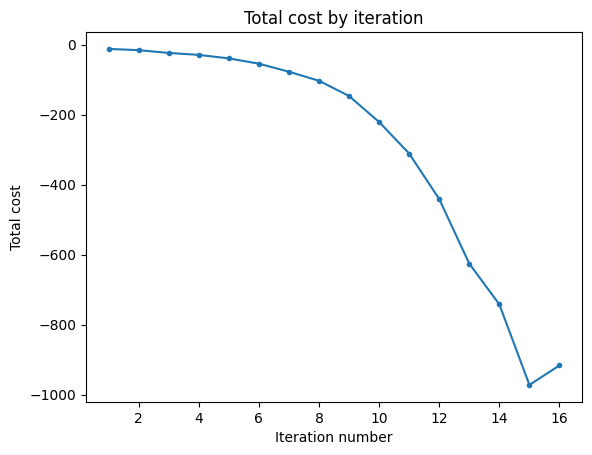

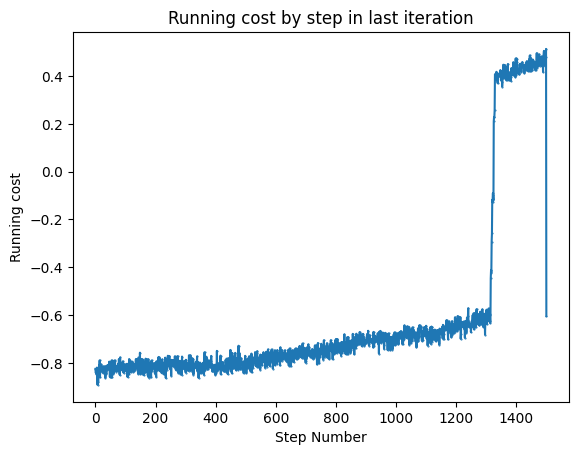

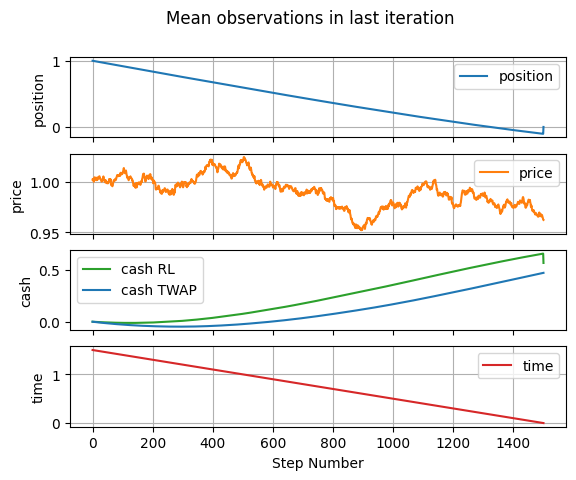

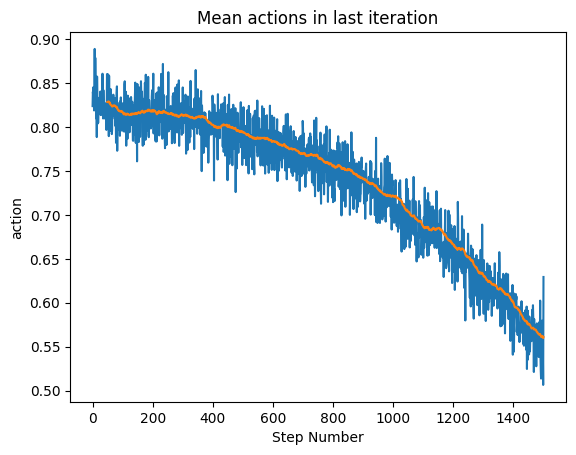

In [4]:
SEED = 0xC0FFEE
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

system = MarketSystem(tpi = 0.01, ppi = 0.001, volatility = 0.1, tc = 0.01, inventory_risk = 0.001)
simulator = EM_Simulator(
    system, N_steps=1500, step_size=0.001, state_init=np.array([[1.0, 1.0, 0.0, 1.502],[1.0, 1.0, 0.0, 1.502]]).T
)
discount_factor = 1

model = GaussianPDFModelCus(
    dim_observation=system.dim_observation,
    dim_action=system.dim_action,
    action_bounds=np.array([[-1, 1]]),
    n_hidden_layers=4,
    scale_factor=50,
    dim_hidden=5,
    std=0.05,
)
critic_model = ModelPerceptron(
    dim_input=system.dim_observation,
    dim_output=1,
    dim_hidden=5,
    n_hidden_layers=5,
)
critic_optimizer = OptimizerSampled(
    model=critic_model,
    opt_method=torch.optim.Adam,
    opt_options=dict(lr=0.05),
    n_epochs=15,
    is_reinstantiate_optimizer=True,
)
critic = Critic(
    td_n=8,
    discount_factor=discount_factor,
    device="cpu",
    model=critic_model,
    optimizer=critic_optimizer,
)
policy_optimizer = OptimizerSampled(
    model=model,
    opt_method=torch.optim.Adam,
    opt_options=dict(lr=0.05),
    is_reinstantiate_optimizer=False,
)
policy = Policy(
    model,
    policy_optimizer,
    critic=critic,
    discount_factor=discount_factor,
)
# This termination criterion never terminates episodes
trivial_terminantion_criterion = lambda *args: False

scenario = MonteCarloSimulationScenario(
    train_mode=True,
    simulator=simulator,
    system=system,
    policy=policy,
    critic=critic,
    N_episodes=6,
    N_iterations=16,
    termination_criterion=trivial_terminantion_criterion,
    discount_factor=discount_factor,
)

try:
    scenario.run()
except KeyboardInterrupt:
    clear_output(wait=True)
    scenario.plot_data()

clear_output(wait=True)
scenario.plot_data()

In [5]:
print('Train Final average CASH:', scenario.last_observations.groupby(scenario.last_observations.index).mean()[2].values[-1])

Train Final average CASH: 0.5672117266641447


In [6]:
print('Train TWAP final mean cash:', pd.DataFrame(scenario.twap).mean().iloc[-1])

Train TWAP final mean cash: 0.4716119843701801


# Testing the results

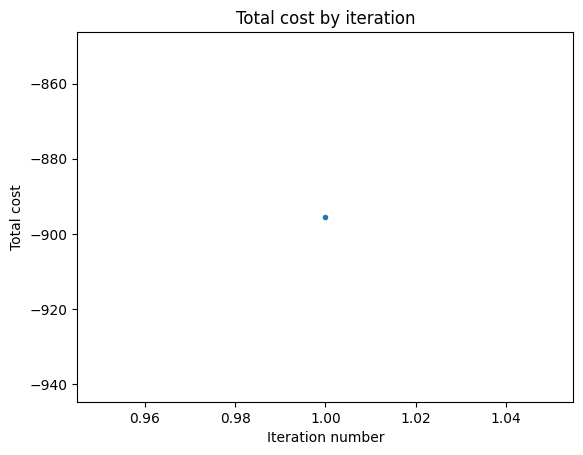

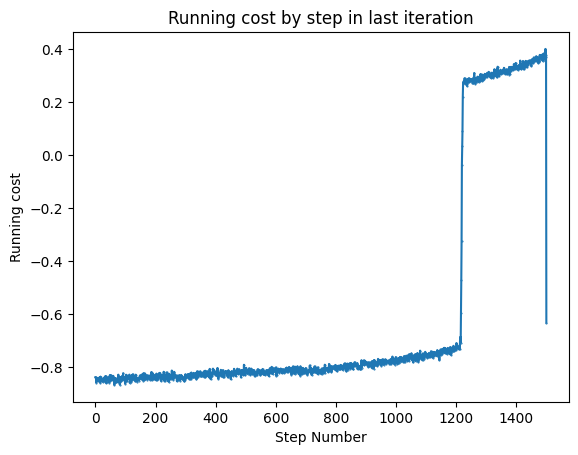

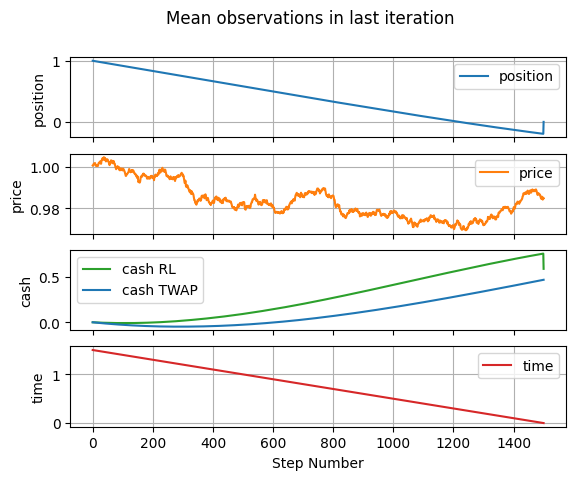

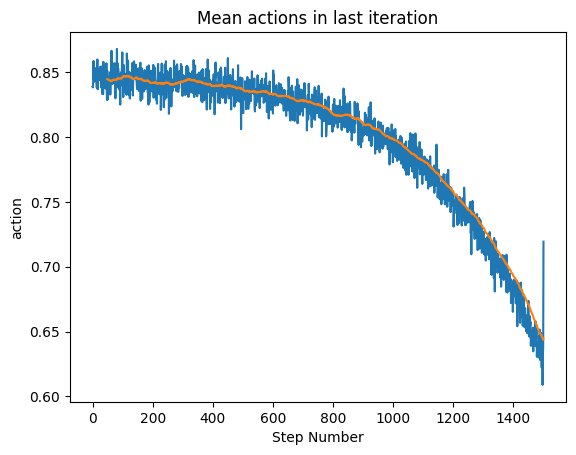

In [7]:
scenario2 = MonteCarloSimulationScenario(
    train_mode=False,
    simulator=simulator,
    system=system,
    policy=policy,
    critic=critic,
    N_episodes=40,
    N_iterations=1,
    termination_criterion=trivial_terminantion_criterion,
    discount_factor=discount_factor,
)

try:
    scenario2.run()
except KeyboardInterrupt:
    clear_output(wait=True)
    scenario2.plot_data()

clear_output(wait=True)
scenario2.plot_data()

In [8]:
print('Test Final average CASH:', scenario2.last_observations.groupby(scenario2.last_observations.index).mean()[2].values[-1])

Test Final average CASH: 0.5851428876196973


In [9]:
print('Test TWAP Final average CASH:', pd.DataFrame(scenario2.twap).mean().iloc[-1])

Test TWAP Final average CASH: 0.4651101183388759


In [10]:
print('Test Final std CASH:', scenario2.last_observations.groupby(scenario2.last_observations.index).std()[2].values[-1])

Test Final std CASH: 0.06365440877884361


In [11]:
print('Test TWAP Final std CASH:', pd.DataFrame(scenario2.twap).std().iloc[-1])

Test TWAP Final std CASH: 0.07109278733716672
